# Detecting Depression through NLP and DL

1. Evelyn Peh Ting Yu
2. Koh Pei Ling
3. Lau Wei Ting
4. Song Yu Xiang
5. Jian Yi
6. Luqman Juzaili

In [189]:
#!pip install transformers==3.0.0

In [190]:
#pip install transformers

In [191]:
#pip install torchvision 

In [192]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [193]:
#pip install pandas#!pip install transformers==3.0.0

#pip install transformers

#pip install torchvision 

# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
#pip install matplotlib
#pip install seaborn
#pip install nltk
#nltk.download('stopwords')
#pip install wordcloud
#pip install scikit-learn

# pip install emoji-unicode
# pip install emoji --upgrade
# pip uninstall emoji
# pip install emoji==1.7

#pip install imblearn

## 1. Import Libraries

In [194]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

# Natural language Processing
import re
import nltk
stop=nltk.corpus.stopwords.words('english')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Emoji
import emoji
from emoji import UNICODE_EMOJI
from nltk.tokenize.casual import TweetTokenizer

# Scikit Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

from collections import defaultdict
from collections import Counter

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
torch.cuda.amp.autocast(enabled=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import time

In [195]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.get_option('max_colwidth')
pd.set_option('max_colwidth', 500)

<hr>

## 2. Import Datasets

<strong> Dataset 1 </strong>

This dataset comprises around 10.1k dataset extracted from Twitter. It consists of 3 columns. The id, tweets and the labels with 1 indicating the person is suffering from depression and 0   for the inverse. Source: https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets

<strong> Dataset 2 </strong>

This dataset comprises around 20k data extracted from Twitter. It consists of information with regards to the post itself: Post_Text, Post_date, Number of retweets, favourites, and have a label as well. Source: https://www.kaggle.com/datasets/infamouscoder/mental-health-social-media?select=Mental-Health-Twitter.csv

In [196]:
df1 = pd.read_csv("sentiment_tweets3.csv")
df2 = pd.read_csv("Mental-Health-Twitter.csv")  # dataset consist of emoji

In [197]:
df1.head()

,Index,message to examine,label (depression result)
0,106,"just had a real good moment. i missssssssss him so much,",0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [198]:
df1.rename(columns={'message to examine':"Message"},inplace=True)
df1.rename(columns={'label (depression result)':"Label"},inplace=True)

In [199]:
df1.columns

Index(['Index', 'Message', 'Label'], dtype='object')

In [200]:
df1.drop(["Index"],inplace=True,axis=1)

In [201]:
df1.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
3,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [202]:
df2.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain has other ideas...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety,1013187241,84,211,251,837,1,1


In [203]:
df2.drop(columns=["Unnamed: 0", "post_id", "post_created","user_id",'followers', 'friends', 'favourites', 'statuses', 'retweets'], inplace=True)

In [204]:
df2.rename(columns={"post_text": "Message"}, inplace=True)
df2.rename(columns={"label": "Label"}, inplace=True)

In [205]:
df2.head()

,Message,Label
0,It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.,1
1,"It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",1
2,Awake but tired. I need to sleep but my brain has other ideas...,1
3,RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…,1
4,It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety,1


###### Merge dataset

In [206]:
df_uncleaned = pd.concat([df1,df2])

In [207]:
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30314 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  30314 non-null  object
 1   Label    30314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 710.5+ KB


In [208]:
df_uncleaned.shape

(30314, 2)

###### Check for null and duplicate

In [209]:
df_uncleaned.duplicated().sum()

543

In [210]:
df_uncleaned.drop_duplicates(inplace=True)

In [211]:
df_uncleaned.shape

(29771, 2)

In [212]:
##Checking for null values
df_uncleaned.isnull().sum()

Message    0
Label      0
dtype: int64

In [213]:
df_uncleaned.columns

Index(['Message', 'Label'], dtype='object')

<hr>

## 2. Exploratory Data Analysis

###### Target Class Distribution

> imbalance dataset with 59% non-depressive, 41% depressive

In [214]:
df_uncleaned.Label.value_counts(normalize = True)

0    0.590037
1    0.409963
Name: Label, dtype: float64

<AxesSubplot:xlabel='Label', ylabel='count'>

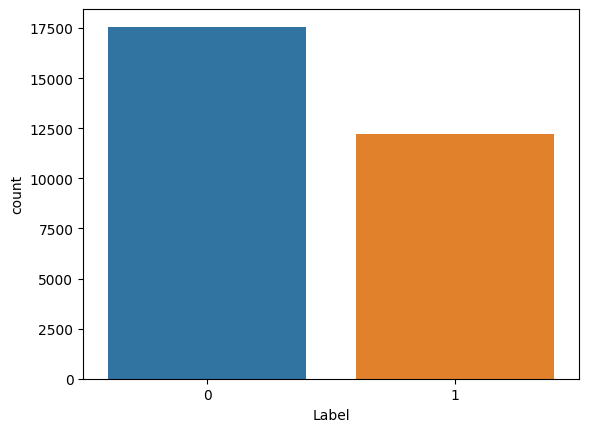

In [215]:
sns.countplot(x=df_uncleaned["Label"])

###### Number of characters in tweets

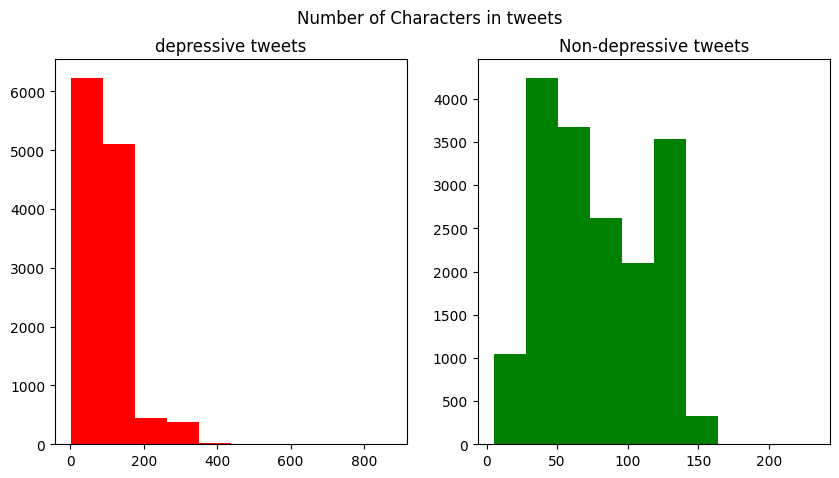

In [216]:
## Number of character
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Number of Characters in tweets')

#depressive
tweet_len=df_uncleaned[df_uncleaned['Label']==1]['Message'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('depressive tweets')

#non-depressive
tweet_len=df_uncleaned[df_uncleaned['Label']==0]['Message'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Non-depressive tweets')

plt.show()

##### Common stopwords in tweets

> In both of classes, "the", "to", "a" dominates 

In [217]:
def create_corpus(target):
    corpus=[]
    
    for x in df_uncleaned[df_uncleaned['Label']==target]['Message'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

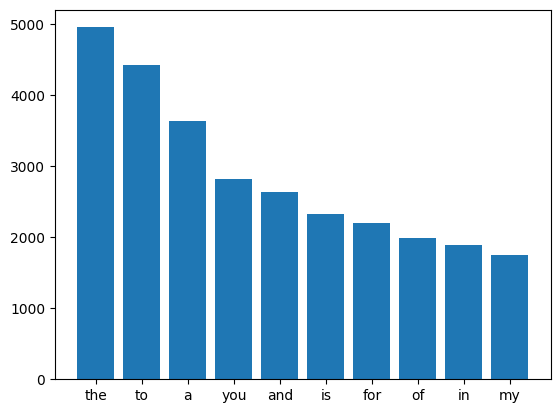

In [218]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

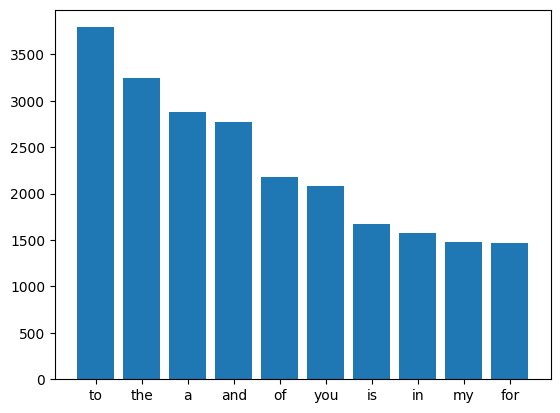

In [219]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

##### Number of Stop Words in a sentence on average 


In [220]:
# This will return us the percentage of Stop Words in Each Tweet. 

percentage_of_stop_word_in_each_tweet = []

def percentage_of_stop_word():
    for x in df_uncleaned['Message']:
        stop_word = 0.0
        total_word_per_sentence = 0.0
        for each_word in x.split(" "):
            if each_word in stop:
                stop_word += 1
            total_word_per_sentence += 1
        
        percentage_of_stop_word_in_each_tweet.append(stop_word/total_word_per_sentence)
    

percentage_of_stop_word()


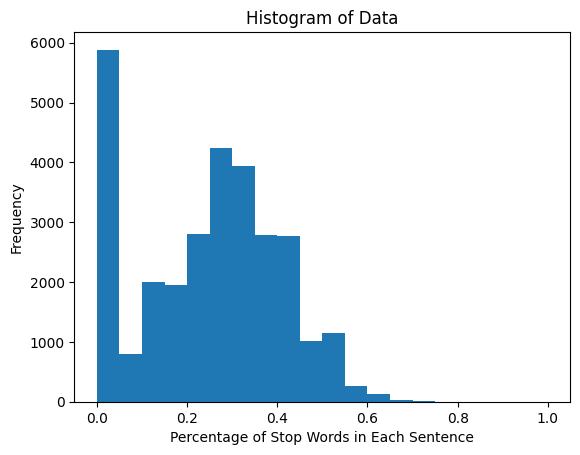

In [221]:
import matplotlib.pyplot as plt

data = percentage_of_stop_word_in_each_tweet

# Create a histogram with 0.05 bin width
bins = list(map(lambda x: x / 20, range(21)))
plt.hist(data, bins=bins)

# Add labels and title
plt.xlabel('Percentage of Stop Words in Each Sentence')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Show the histogram
plt.show()


##### Common punctuation in tweets

<BarContainer object of 25 artists>

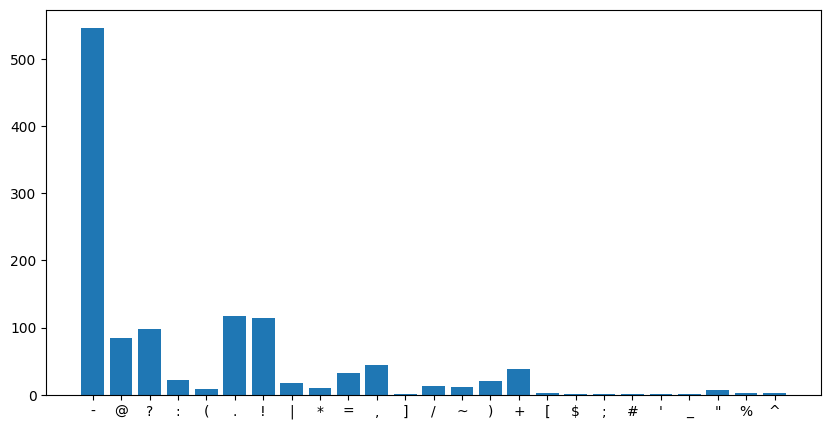

In [222]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 23 artists>

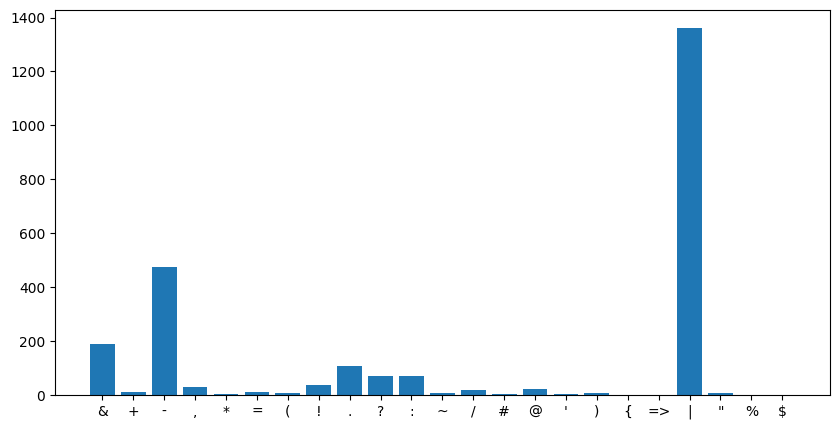

In [223]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

##### Common Words

> it can be see that the common words are stop words which implies that data cleaning is neccessary

In [224]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

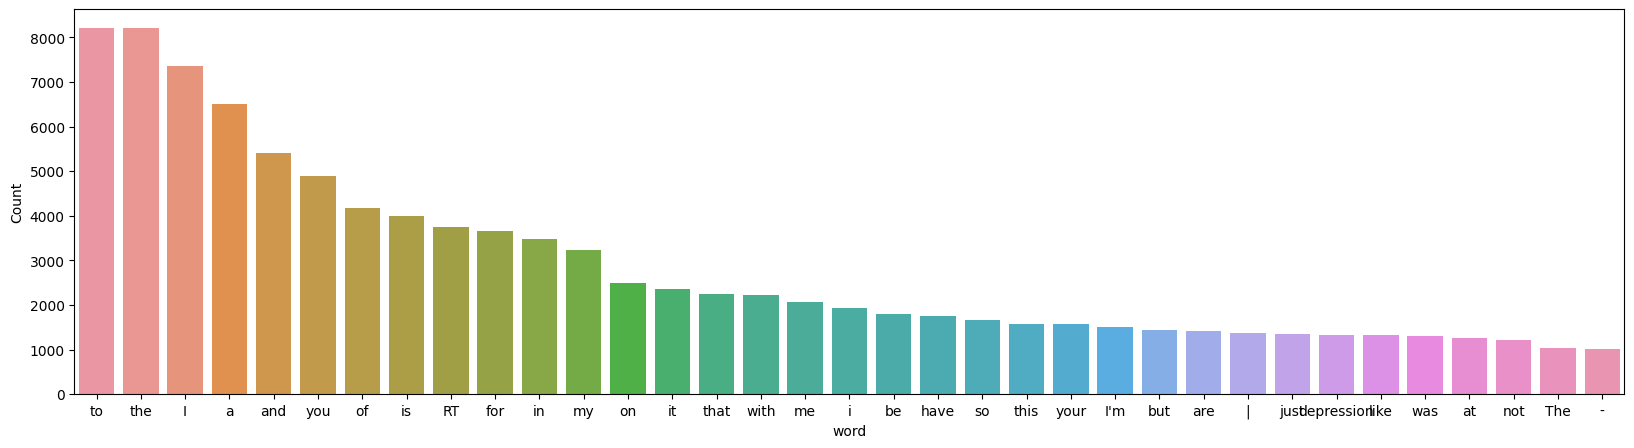

In [225]:
freq_words(df_uncleaned['Message'], 35)

###### Common Words - Bi-Gram Analysis

Bigram (n=2) analysis over the tweets to check the most common bigrams in tweets.

In [226]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

> The most frequent words are often unimportant words such as https which is an internet protocol and other words that does not echo much meaning for people identified with depression. Therefore, there is a need of thorough data cleaning 


<AxesSubplot:>

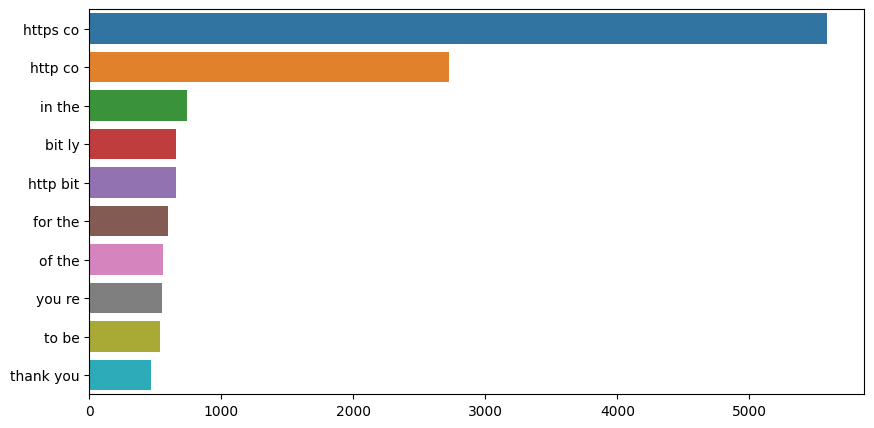

In [227]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_uncleaned['Message'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#### Word Cloud Visualization

Depression Class

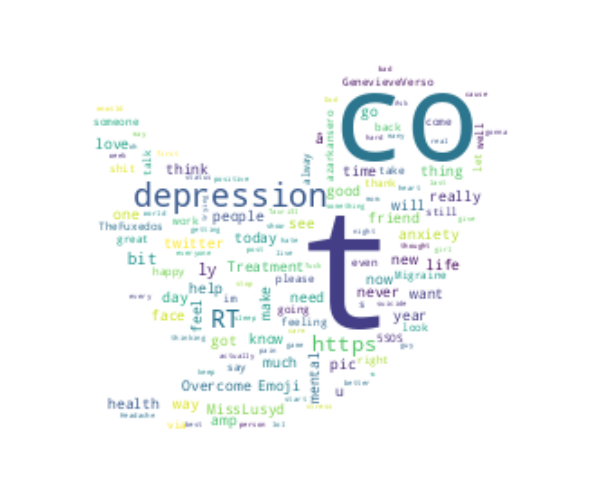

In [228]:
depressive_words = ' '.join(list(df_uncleaned[df_uncleaned['Label'] == 1]['Message']))
mask = np.array(Image.open("Twitter.png"))
depressive_wc = WordCloud(collocations=False, mask=mask, background_color="white").generate(depressive_words)
plt.figure(figsize = (8, 6))
plt.imshow(depressive_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Non-Depression Class

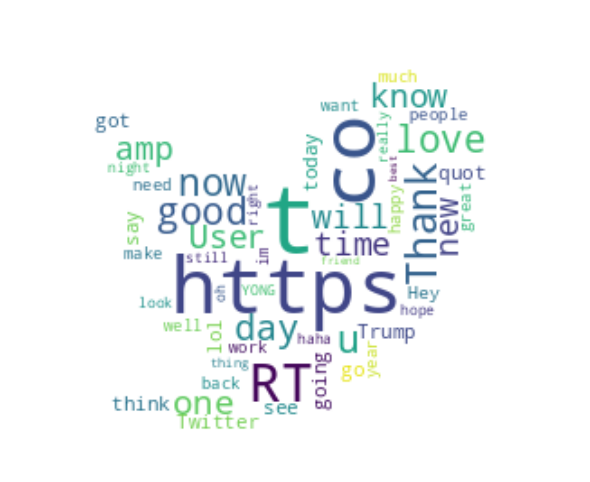

In [229]:
nondepressive_words = ' '.join(list(df_uncleaned[df_uncleaned['Label'] == 0]['Message']))
mask = np.array(Image.open("Twitter.png"))
nondepressive_wc = WordCloud(collocations=False, mask=mask, background_color="white").generate(nondepressive_words)
plt.figure(figsize = (8, 6))
plt.imshow(nondepressive_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Data Cleaning

In [230]:
## Remerge the data after dropping all RT in the 2nd data set -- substr = "RT @" 
df2 = df2[~df2.Message.str.contains("RT @")]
df_uncleaned = pd.concat([df1,df2])

In [231]:
df_uncleaned.shape

(26609, 2)

###### Convert to Lower Case 

In [232]:
def text_to_lower(text):
    text = text.lower()
    return text

In [233]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:text_to_lower(x))

In [234]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of HTML entities 

In [235]:
# These are the HTML Entities 
html_entities = {'&nbsp;': '', '&iexcl;': '', '&cent;': '', '&pound;': '', '&curren;': '', '&yen;': '', '&brvbar;': '', 
                  '&sect;': '', '&uml;': '', '&copy;': '', '&reg;': '', '&trade;': '', '&macr;': '', '&deg;': '', 
                  '&plusmn;': '', '&sup2;': '', '&sup3;': '', '&acute;': '', '&micro;': '', '&para;': '', '&middot;': '', 
                  '&cedil;': '', '&sup1;': '', '&ordm;': '', '&raquo;': '', '&frac14;': '', '&frac12;': '', '&frac34;': '', 
                  '&iquest;': '', '&Agrave;': '', '&Aacute;': '', '&Acirc;': '', '&Atilde;': '', '&Auml;': '', 
                  '&Aring;': '', '&AElig;': '', '&Ccedil;': '', '&Egrave;': '', '&Eacute;': '', '&Ecirc;': '', '&Euml;': '', 
                  '&Igrave;': '', '&Iacute;': '', '&Icirc;': '', '&Iuml;': '', '&ETH;': '', '&Ntilde;': '', '&Ograve;': '', 
                  '&Oacute;': '', '&Ocirc;': '', '&Otilde;': '', '&Ouml;': '', '&times;': '', '&Oslash;': '', 
                  '&Ugrave;': '', '&Uacute;': '', '&Ucirc;': '', '&Uuml;': '', '&Yacute;': '', '&THORN;': '', '&szlig;': '', 
                  '&agrave;': '', '&aacute;': '', '&acirc;': '', '&atilde;': '', '&auml;': '', '&aring;': '', '&aelig;': '', 
                  '&ccedil;': '', '&egrave;': '', '&eacute;': '', '&ecirc;': '', '&euml;': '', '&igrave;': '', '&iacute;': '', 
                  '&icirc;': '', '&iuml;': '', '&eth;': '', '&ntilde;': '', '&ograve;': '', '&oacute;': '', '&ocirc;': '', 
                  '&otilde;': '', '&ouml;': '', '&divide;': '','&amp;': '', '&lt;': '', '&gt;': '', '&quot;': '', '&apos;': ''}

In [236]:
html_re = re.compile('(%s)' % '|'.join(html_entities.keys()))

def replace_html_entities(text,contractions_dict=html_entities):
    def replace(match):
        return html_entities[match.group(0)]
    return html_re.sub(replace, text)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:replace_html_entities(x))


In [237]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Hashtags

In [238]:
# Removal of HashTag
def remove_hashtags (text):
    text = re.sub(r"#\w+", '', text, flags=re.MULTILINE)
    return(text)


In [239]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_hashtags(x))

In [240]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Conversion of contractions

In [241]:
# Converting it to string type
df_uncleaned['Message'] = df_uncleaned['Message'].astype("str")
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26609 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  26609 non-null  object
 1   Label    26609 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 623.6+ KB


In [242]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have",
                    
                    "aint": "are not","'s":" is","arent": "are not",
                     "cant": "cannot","cantve": "cannot have",
                     "'cause": "because","couldve": "could have","couldnt": "could not",
                     "couldntve": "could not have", "didnt": "did not","doesnt": "does not",
                     "dont": "do not","hadnt": "had not","hadnt've": "had not have",
                     "hasnt": "has not","havent": "have not","hed": "he would",
                     "hedve": "he would have","hell": "he will", "hellve": "he will have",
                     "howd": "how did","howdy": "how do you","howll": "how will",
                     "id": "i would", "id've": "i would have","ill": "i will",
                     "illve": "i will have","im": "i am","ive": "i have", "isnt": "is not",
                     "itd": "it would","itd've": "it would have","itll": "it will",
                     "itll've": "it will have", "lets": "let us","maam": "madam",
                     "maynt": "may not","mightve": "might have","mightnt": "might not", 
                     "mightntve": "might not have","mustve": "must have","mustnt": "must not",
                     "mustn'tve": "must not have", "neednt": "need not",
                     "needn'tve": "need not have","oclock": "of the clock","oughtnt": "ought not",
                     "oughtntve": "ought not have","shant": "shall not","shant": "shall not",
                     "shantve": "shall not have","shed": "she would","shedve": "she would have",
                     "shell": "she will", "shellve": "she will have","shouldve": "should have",
                     "shouldnt": "should not", "shouldntve": "should not have","sove": "so have",
                     "thatd": "that would","thatdve": "that would have", "thered": "there would",
                     "theredve": "there would have", "theyd": "they would",
                     "theydve": "they would have","theyll": "they will",
                     "theyllve": "they will have", "theyre": "they are","theyve": "they have",
                     "tove": "to have","wasnt": "was not","wed": "we would",
                     "wedve": "we would have","well": "we will","well've": "we will have",
                     "were": "we are","weve": "we have", "werent": "were not","whatll": "what will",
                     "whatllve": "what will have","whatre": "what are", "whatve": "what have",
                     "whenve": "when have","whered": "where did", "whereve": "where have",
                     "wholl": "who will","whollve": "who will have","whove": "who have",
                     "whyve": "why have","willve": "will have","wont": "will not",
                     "wontve": "will not have", "wouldve": "would have","wouldnt": "would not",
                     "wouldntve": "would not have","yall": "you all", "yalld": "you all would",
                     "yalldve": "you all would have","yallre": "you all are",
                     "yallve": "you all have", "youd": "you would","youdve": "you would have",
                     "youll": "you will","youllve": "you will have", "youre": "you are",
                     "youve": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [243]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:expand_contractions(x))

In [244]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of URL

In [245]:
def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return(text)

In [246]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_urls(x))

In [247]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga,0
2,@comeagainjen -,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Mentions/Retweets User Accounts 

In [248]:
def remove_mentions_user (text):
    text = re.sub(r"@\w+", '', text, flags=re.MULTILINE)
    return(text)

In [249]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_mentions_user(x))

In [250]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga,0
2,-,0
3,"need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Punctuation

In [251]:
def remove_punctuations (text):
    text = re.sub(r"""[!"¦#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""", '', text, flags=re.MULTILINE)
    return(text)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_punctuations(x))

In [252]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Removal of numbers

In [253]:
df_uncleaned['Message'] = df_uncleaned['Message'].str.replace('\d+', '')

/common/home/users/j/jianyi.lye.2020/jupyterlab-venv-tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [254]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Emojis to textual description conversion

Translate emojis to their textual description. This is to ensure that the sentiment value that an emoji contain will also be considered by the model in future parts.
- Utilise TweetTokenizer to split tweets on a list of words, while treating the emoji as a word itself.
- Utilise Emoji demojize to convert the graphical representation of the emoji to its textual representation which seperated by underscore when the description is more than 1 word e.g., smiling_beaming_face, tears_of_joy
- Seperate the textual description of emojis e.g, "smiling_beaming_face" as ['smiling','beaming','face'] to consider it as normal words

#### Need to choose one method (How do we store emoji textual description)

In [255]:
# helper function for convert_emojis; return true if token is an emoji
def is_emoji(s):
    return s in UNICODE_EMOJI

# Break up sentences into list of words while considering emojis
def store_emojis(text):
    
    # break up tweets into words while considering emojis as itself e.g., ['this','is','cool','😁','👍']
    tweet_list = TweetTokenizer().tokenize(text)
    tweet_string = convert_emojis(tweet_list)
    return tweet_string

def convert_emojis(text):
    new_text = []
    
    for i in range(len(text)):
        if is_emoji(text[i]):
            temp = emoji.demojize(text[i], delimiters=("",""))
            
            if "_" in temp:
                temp = temp.split("_")
            
            for item in temp:
                new_text.append(item)
        else:
            new_text.append(text[i])
        
    return ' '.join([str(item) for item in new_text])

In [256]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:store_emojis(x))

In [257]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Removal of StopWords 


In [258]:
stopWords = set(stopwords.words('english'))

In [259]:
from string import printable
st = set(printable)
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x: ''.join([" " if  i not in  st else i for i in x]))

In [260]:
import nltk 
def remove_stopwords(paragraph):
    words = nltk.word_tokenize(paragraph)
    wordlist_wo_stopwords=[]
    for w in words:
        if w not in stopWords:
            wordlist_wo_stopwords.append(w)
    return wordlist_wo_stopwords

df_uncleaned['Message'] = df_uncleaned['Message'].astype(str)
df_uncleaned['Message'] = df_uncleaned['Message'].str.replace('[^a-zA-Z0-9]', ' ', regex=True).str.strip()
df_uncleaned['Message'] = df_uncleaned['Message'].apply(remove_stopwords)

In [261]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x: ' '.join(x))

In [262]:
df_uncleaned.head()

,Message,Label
0,real good moment missssssssss hi much,0
1,reading manga,0
2,,0
3,need send em accountant tomorrow oddly even referring taxes supporting evi wouldence though,0
4,add myspace myspacecomlookthunder,0


###### Tokenisation 

Remove Stop words first then tokenise
- What is tokenization? In essence, it’s splitting a string into smaller units (tokens) 

- After tokenizing the sentence we are provided with a list of all words (and signs) within the sentence. Another common method is sentence tokenization, which splits the text into a list of sentences --> i think maybe no need 

https://www.dataquest.io/blog/how-to-clean-and-prepare-your-data-for-analysis/

In [263]:
# nltk.download('punkt')

In [264]:

df_uncleaned['Tokenised'] = df_uncleaned['Message'].apply(word_tokenize)

In [265]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment missssssssss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even referring taxes supporting evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


###### Lemmatization
Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning.

In [266]:
#nltk.download('averaged_perceptron_tagger')

In [267]:
#nltk.download('all')

In [268]:
lemmatizer = WordNetLemmatizer()

def lemmatize_it(text):
    empty = []
    for word, tag in pos_tag(word_tokenize(text)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
            empty.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
            empty.append(lemma)
    return ' '.join(empty)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lemmatize_it)

In [269]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment miss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


<hr>

### 4. Exploratory Data Analysis on Cleaened Dataset

> Getting the most popular words for the whole dataset

In [270]:
# function for checking popular words:
def popular_words(series):
    top = Counter([item for sublist in df_uncleaned['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned['Message'])

,Common_words,count
0,depression,2965
1,would,2140
2,like,1353
3,good,1042
4,ame,995
5,ti,994
6,get,976
7,love,954
8,one,932
9,know,902


**Insights**: We are able to observe the top 20 most common words in the dataset. This will provide us with insights of what words are more significant than the others in detecting depression. More specifically, we will be interested to know how many of these words are from depressed labelled tweets.

> Getting the most popular words for the whole dataset for depressed labelled tweets

In [271]:
df_uncleaned.shape

(26609, 3)

In [272]:
df_uncleaned_depressed = df_uncleaned[df_uncleaned["Label"] == 1] 
df_uncleaned_depressed.shape

(10495, 3)

In [273]:
from collections import Counter

# function for checking popular words in depressed labels:
def popular_words(series):
#     data1['temp_list'] = series.apply(lambda x:str(x).split())
    top = Counter([item for sublist in df_uncleaned_depressed['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned_depressed['Message'])

,Common_words,count
0,depression,2961
1,would,843
2,like,619
3,get,450
4,people,398
5,ti,386
6,one,386
7,know,374
8,anxiety,364
9,ame,337


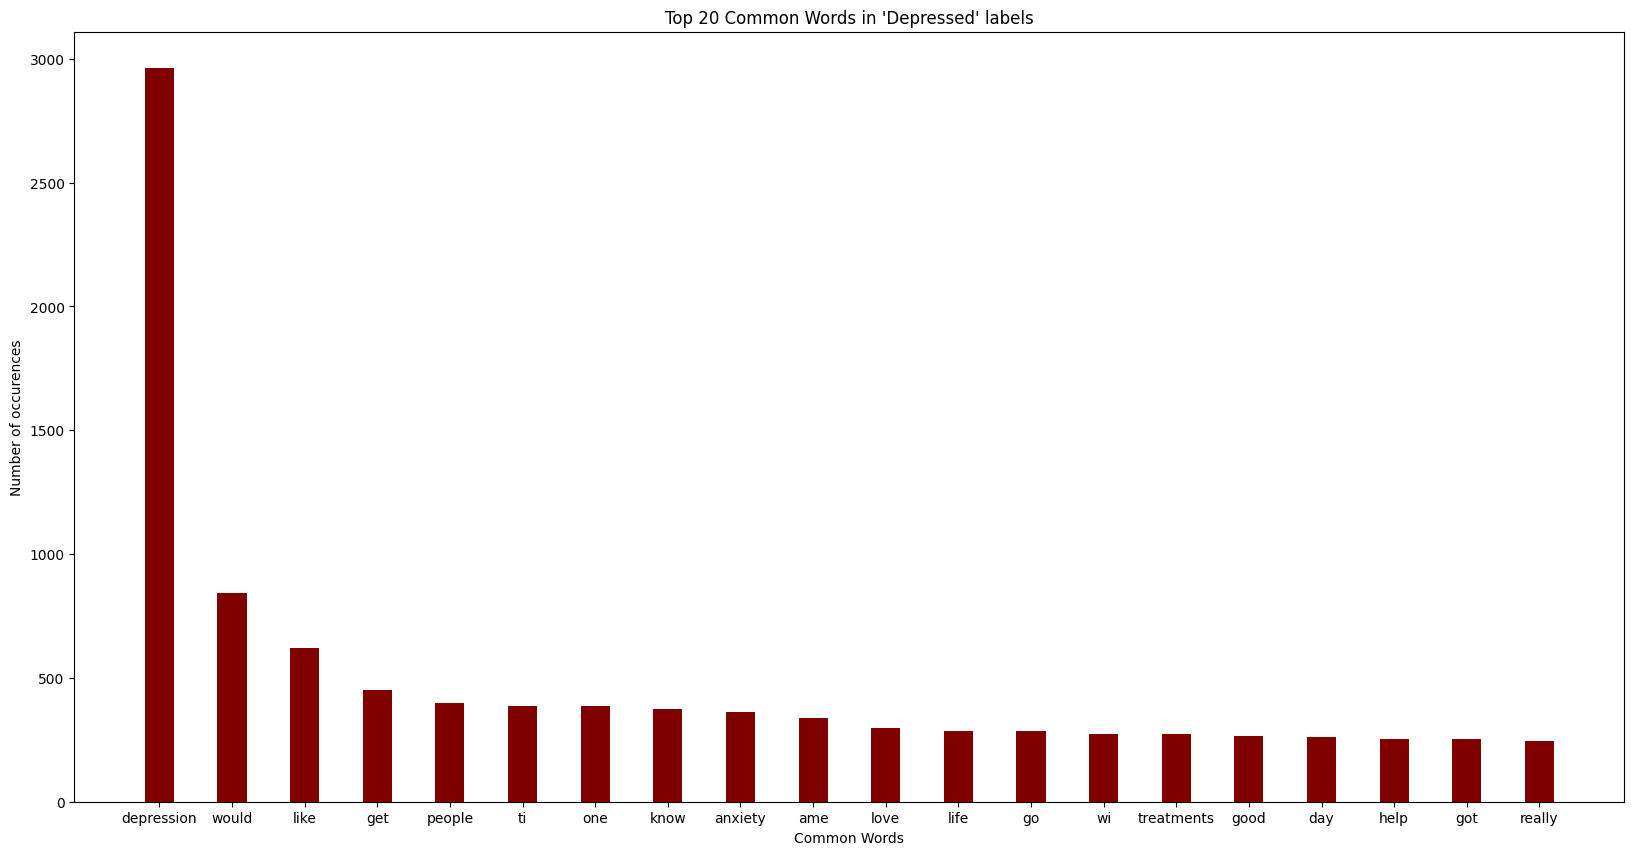

In [274]:
## Visualise in Bar Graph (Popular Words in depressed label)
import matplotlib.pyplot as plt

depressed_words_df = popular_words(df_uncleaned_depressed['Message'])
# depressed_words_df = temp_df.groupby('Common_words').sum().sort_values(by='count',ascending=False)

depressed_words_df
# courses = list(depressed_words_df.keys())
# values = list(depressed_words_df.values())

common_words_list = []
count_list = []

for index, row in depressed_words_df.iterrows():
    common_words_list.append(row['Common_words'])
    count_list.append(row['count'])
    

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(common_words_list, count_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Top 20 Common Words in 'Depressed' labels")
plt.show()


**Insights**: After taking a deeper look at only depressed labelled tweets, we are able to notice extra words such as "treatments" and "help" to name a few. We are able to also observe that there are many words that are common in the whole dataset also appear for the most common words of depressed labelled tweets. However, some of these words may also appear in non depressed label tweets. Therefore, further filtering can be done to find out the most common words that strictly only appear for depressed labelled tweets to ensure only words representative of the label is extracted.

> Getting the most popular words for the whole dataset for non-depressed labelled tweets

In [275]:
# Find Common Words in non-depressed labels (To see if they are overlaps)
df_uncleaned_nondepressed =df_uncleaned[df_uncleaned["Label"] == 0] 
df_uncleaned_nondepressed.shape

(16114, 3)

In [276]:
# function for checking popular words in non-depressed labels:
def popular_words(series):
#     data1['temp_list'] = series.apply(lambda x:str(x).split())
    top = Counter([item for sublist in df_uncleaned_nondepressed['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned_nondepressed['Message'])

,Common_words,count
0,would,1297
1,good,778
2,like,734
3,ame,658
4,love,656
5,ti,608
6,wi,582
7,day,559
8,one,546
9,know,528


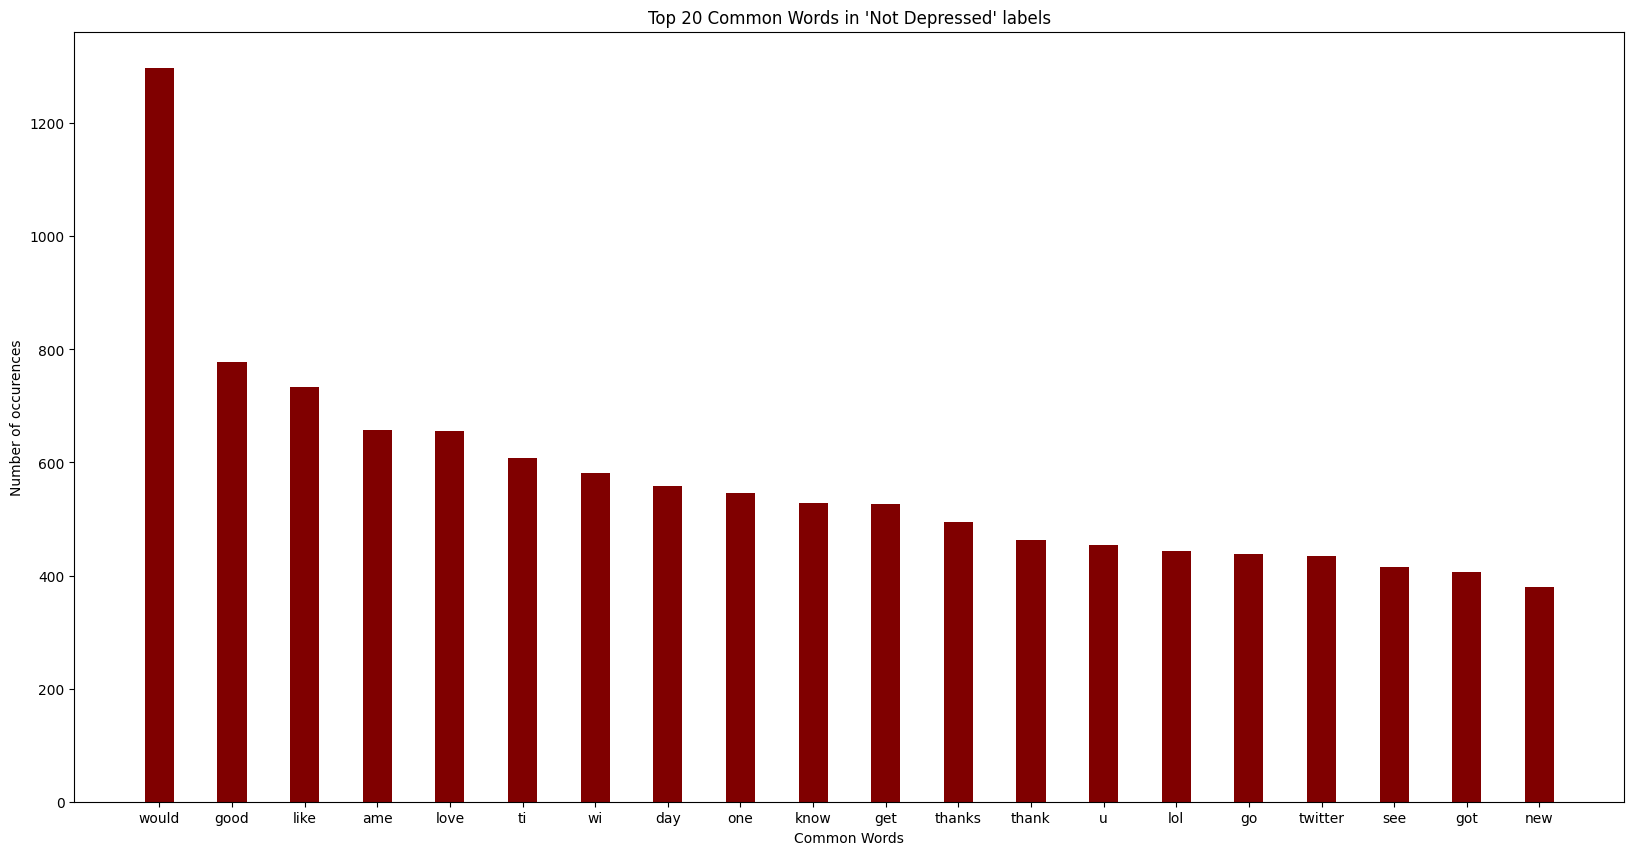

In [277]:
nondepressed_words_df = popular_words(df_uncleaned_nondepressed['Message'])
nondepressed_words_df

common_words_list = []
count_list = []

for index, row in nondepressed_words_df.iterrows():
    common_words_list.append(row['Common_words'])
    count_list.append(row['count'])
    

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(common_words_list, count_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Top 20 Common Words in 'Not Depressed' labels")
plt.show()

**Insights**: Looking at the common words in the non depressed label tweets, we are able to see words like "would" and "like" which appears in both depressed and non depressed label tweets. We need to filter any other words that may exist in both labels to ensure that we can extract the unique common words of the depressed label tweets.

> Getting the most common unique words for depressed labelled tweets (top words that only appears in depressed labelled tweets)

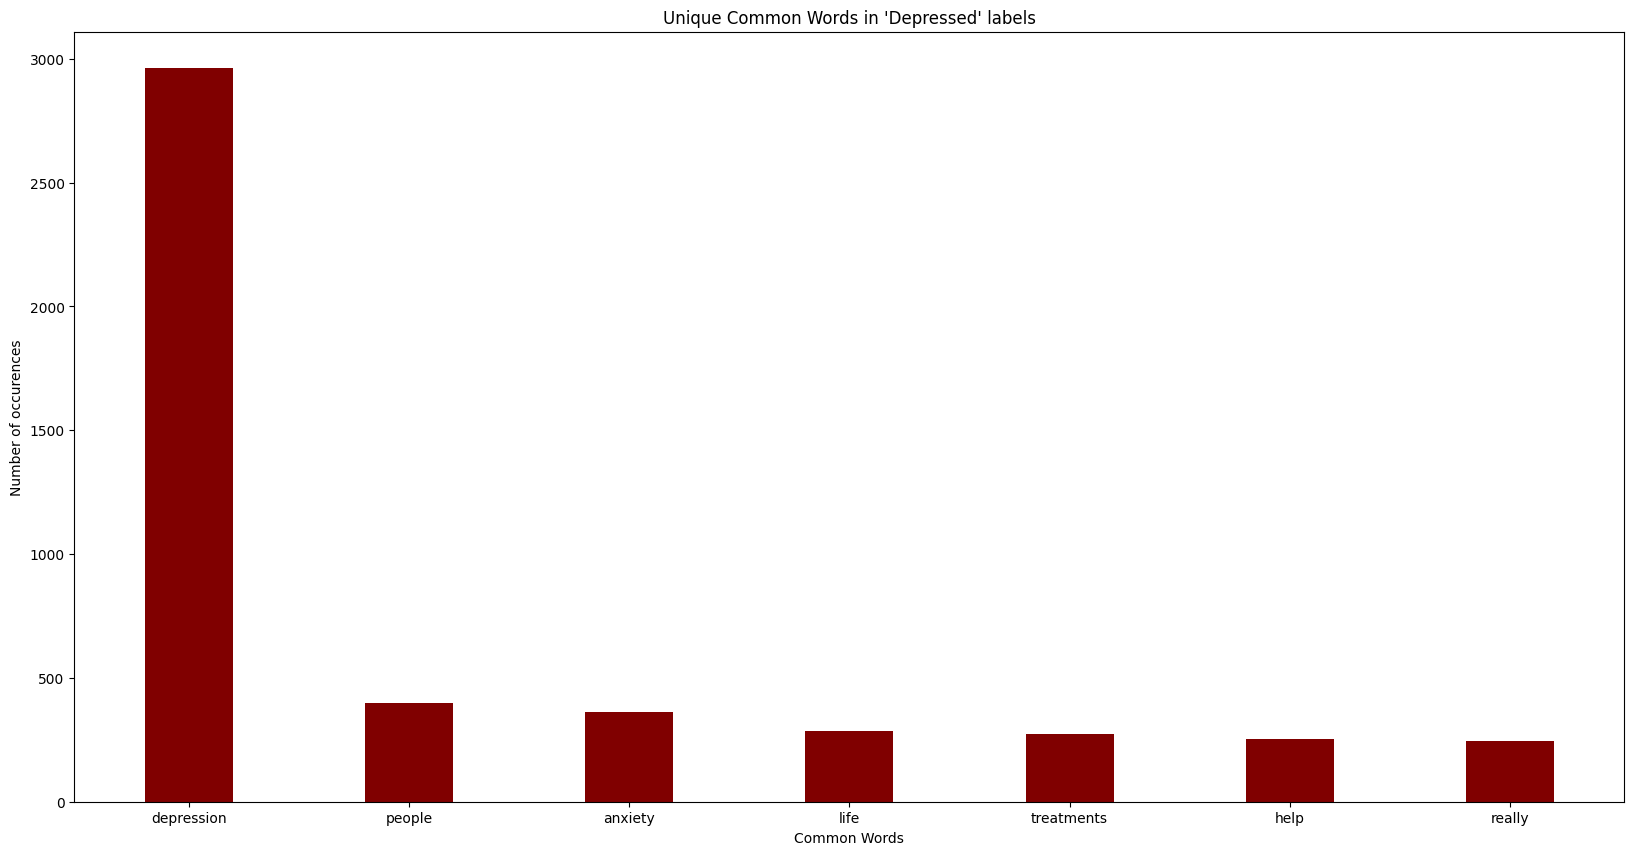

In [278]:
#Find common words in depressed labels that do not appear in non depressed labels

# Depressed dataframe
depressed_words_df

depressed_words = []
depressed_count = []

for index, row in depressed_words_df.iterrows():
    depressed_words.append(row['Common_words'])
    depressed_count.append(row['count'])

# Non Depressed dataframe
nondepressed_words_df

nondepressed_words = []
nondepressed_count = []

for index, row in nondepressed_words_df.iterrows():
    nondepressed_words.append(row['Common_words'])
    nondepressed_count.append(row['count'])


unique_depressed_words = []
unique_depressed_count = []

for i in range(len(depressed_words)):
    if depressed_words[i] not in nondepressed_words:
        unique_depressed_words.append(depressed_words[i])
        unique_depressed_count.append(depressed_count[i])

        
# Plot Bar Graph
fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(unique_depressed_words, unique_depressed_count, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Unique Common Words in 'Depressed' labels")
plt.show()

**Insights**: After obtaining the unique words for the depressed label tweets, we are able to identify 8 unique words that only exist in the depressed labelled tweets.

<hr>

### 5. Preparing Dataset for Model Training


In [279]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment miss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


In [280]:
df_cleaned = df_uncleaned[["Message","Label"]]

In [281]:
df_cleaned.reset_index(inplace=True)

In [282]:
df_cleaned.head()

,index,Message,Label
0,0,real good moment miss hi much,0
1,1,reading manga,0
2,2,,0
3,3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0
4,4,add myspace myspacecomlookthunder,0


In [283]:
df_cleaned.shape

(26609, 3)

In [284]:
list_of_index = df_cleaned[df_cleaned['Message'] == ''].index.values.tolist()
print(f'number of row with empty string: {len(list_of_index)}')

number of row with empty string: 147


In [285]:
df_cleaned.iloc[list_of_index]

,index,Message,Label
2,2,,0
156,156,,0
263,263,,0
526,526,,0
718,718,,0
778,778,,0
809,809,,0
1233,1233,,0
1461,1461,,0
1480,1480,,0


##### Drop row with empty string

In [286]:
df_cleaned.drop(index=list_of_index, inplace = True)

/common/home/users/j/jianyi.lye.2020/jupyterlab-venv-tf/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [287]:
df_cleaned.shape

(26462, 3)

<hr>

In [288]:
X = df_cleaned.Message
y = df_cleaned.Label

In [289]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

<hr>

## Word2Vec (Vector form of words) or Doc2Vec (Vector form of sentences)


Two variants:

1) CBOW - predict the target word from the context 

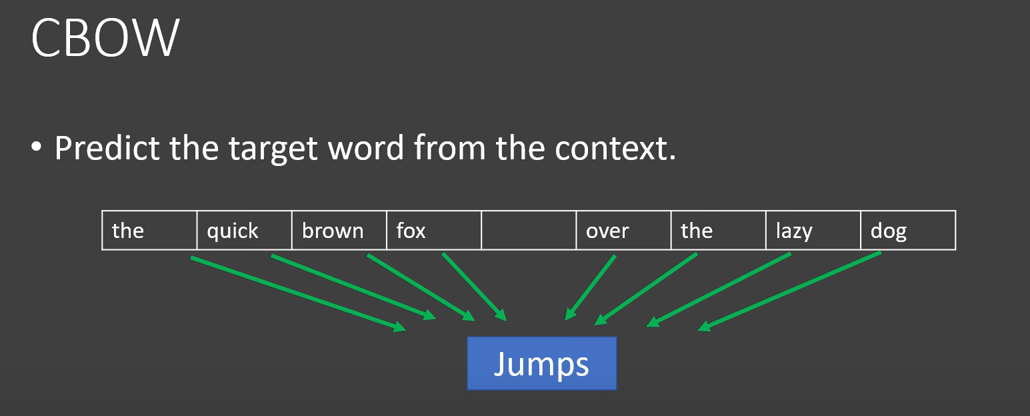

2) Skip gram - predict context words from target 

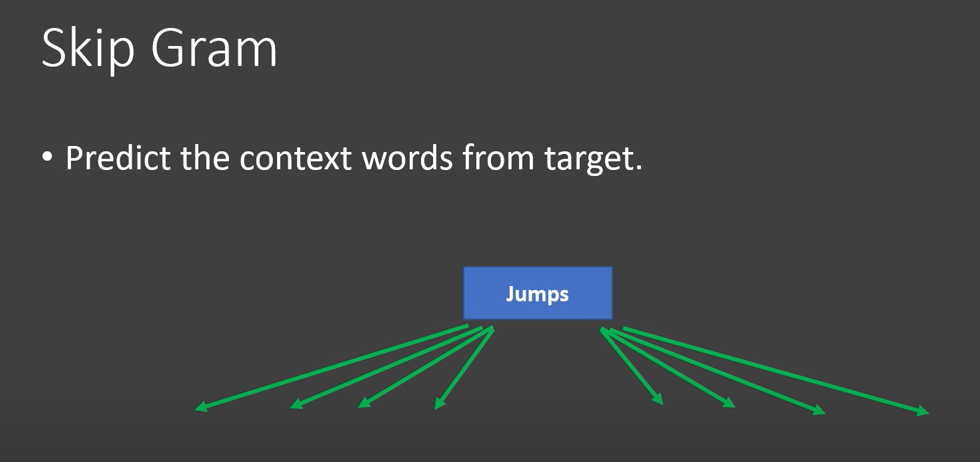

Word2Vec is a technique for generating word embeddings that can capture semantic relationships between words. It works by training a neural network to predict the context of a word based on its surrounding words. This can be useful for detecting depression-related words in the tweets and identifying their relationships with other words in the sentences. However, it does not take into account the context of the entire sentence or document.

Doc2Vec, on the other hand, extends Word2Vec to generate document embeddings that can capture the semantic relationships between entire documents. It works by training a neural network to predict the context of a document based on its constituent words. This can be useful for capturing the overall sentiment of a tweet and identifying the relationships between tweets in the dataset.

If your goal is to identify individual depression-related words in the tweets, Word2Vec may be more appropriate. However, if you want to capture the overall sentiment of the tweets and identify the relationships between them, Doc2Vec may be more suitable. You may also consider using both techniques in combination to achieve a more comprehensive analysis of the dataset.

## Word2Vec - Non Contextual 

contextual - BERT 

https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

The word2vec algorithm is an approach to learning a word embedding from a text corpus in a standalone way. The benefit of the method is that it can produce high-quality word embeddings very efficiently, in terms of space and time complexity.

In [295]:
df_uncleaned.sample(10)

,Message,Label,Tokenised
18300,userdexter,0,[userdexter]
762,gon na restart computer super quick min,0,"[gon, na, restart, computer, super, quick, mins]"
3062,stretche would pahwsjaboj,1,"[stretche, would, pahwsjaboj]"
19072,ri haverdayspa,0,"[ri, haverdayspa]"
1294,invigorate yoga pose sweat asana via mbg,1,"[invigorating, yoga, poses, sweat, asana, via, mbg]"
4719,liar liar dvd inexplicably play french happy tv tonight french use,1,"[liar, liar, dvd, inexplicably, plays, french, happy, tv, tonight, french, used]"
16256,amori way reply tweet wi backfire kena batang hi wouldung sendiri,0,"[amori, ways, reply, tweet, wi, backfire, kena, batang, hi, wouldung, sendiri]"
19310,usermahavir gundecha,0,"[usermahavir, gundecha]"
8974,use doodle get trouble,1,"[used, doodle, got, trouble]"
3668,go relax sun,0,"[go, relax, sun]"


In [296]:
df_uncleaned['Tokenised'].isnull().sum()

0

In [297]:
# nltk(nltk.download('all'))
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [298]:
# Convert the messages to a list of words
sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# Set the parameters for the Word2Vec model
embedding_size = 100
window_size = 5
min_word_count = 1
num_iterations = 50

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, 
                      min_count=min_word_count, workers=4, epochs=num_iterations)

# Create a dictionary of word vectors
word_vectors = w2v_model.wv

In [299]:
# Define a function to convert messages to vectors
def message_to_vector(message, max_len):
    words = message.split()
    word_vectors = [w2v_model.wv.get_vector(word) for word in words if word in w2v_model.wv.key_to_index]
    if not word_vectors:
        return np.zeros((max_len, embedding_size))
    padded_vectors = pad_sequences([word_vectors], maxlen=max_len, dtype='float32', padding='post', truncating='post')
    return padded_vectors[0]

# Convert the messages to vectors
max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
X = np.array([message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()])

# Convert the labels to one-hot encoding
y = to_categorical(df_cleaned["Label"], dtype='float32')

In [300]:
X

array([[[-0.24664891,  0.55544406,  0.96003777, ...,  0.2153121 ,
          0.6694375 , -0.13041982],
        [-0.08519997, -1.547015  , -0.8985537 , ...,  0.44042966,
          0.12418029,  1.494886  ],
        [-0.1379628 , -0.23617283,  0.46718296, ...,  0.8226408 ,
         -0.7771711 , -0.19089203],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.2281987 ,  0.49528864, -0.00617739, ..., -0.51835334,
          1.0257921 ,  0.08177069],
        [ 0.04328692, -0.025717  ,  0.12736344, ..., -0.28079018,
          0.280749  , -0.0708244 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [301]:
y


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Word2Vec + CNN

In [302]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

# Define the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu', padding='same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=5e-5, epsilon=1e-8)
model.compile(loss=binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 15876 samples, validate on 3970 samples
Epoch 1/10
15876/15876 [==============================] - 8s 526us/sample - loss: 0.6415 - acc: 0.6490 - val_loss: 0.5822 - val_acc: 0.7358
Epoch 2/10
15876/15876 [==============================] - 8s 485us/sample - loss: 0.5610 - acc: 0.7263 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 3/10
15876/15876 [==============================] - 8s 483us/sample - loss: 0.5337 - acc: 0.7376 - val_loss: 0.5352 - val_acc: 0.7428
Epoch 4/10
15876/15876 [==============================] - 8s 484us/sample - loss: 0.5204 - acc: 0.7447 - val_loss: 0.5308 - val_acc: 0.7476
Epoch 5/10
15876/15876 [==============================] - 8s 484us/sample - loss: 0.5110 - acc: 0.7477 - val_loss: 0.5253 - val_acc: 0.7491
Epoch 6/10
15876/15876 [==============================] - 8s 486us/sample - loss: 0.5042 - acc: 0.7506 - val_loss: 0.5213 - val_acc: 0.7486
Epoch 7/10
15876/15876 [==============================] - 8s 486us/sample - loss: 0.4975 - acc: 0.7526 - val_lo

In [303]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 51, 128)           38528     
_________________________________________________________________
dropout_18 (Dropout)         (None, 51, 128)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 25, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 25, 128)           65664     
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 12, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 12, 128)          

In [304]:
y_test.shape

(6616, 2)

In [305]:
# Evaluate the model on the test set
test_loss,test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

# Generate predictions
y_pred = model.predict(X_test)
# Convert predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print classification report
print('Test Classification Report:')
print(report)

6616/6616 [==============================] - 1s 109us/sample - loss: 0.5066 - acc: 0.7578
Test loss: 0.5065721661897495
Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      4004
           1       0.82      0.50      0.62      2612

    accuracy                           0.76      6616
   macro avg       0.78      0.71      0.72      6616
weighted avg       0.77      0.76      0.74      6616



## Word2Vec + RNN

In [306]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Convert the labels to integer labels
le = LabelEncoder()
y = le.fit_transform(df_cleaned["Label"])

# Apply one-hot encoding to the integer labels
y = to_categorical(y)

In [307]:
##only compatible with tensorflow 1.15

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

# Convert the messages to a list of words
sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# Set the parameters for the Word2Vec model
embedding_size = 100
window_size = 5
min_word_count = 1
num_iterations = 50

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, 
                      min_count=min_word_count, workers=4, epochs=num_iterations)

# Create a dictionary of word vectors
word_vectors = w2v_model.wv

# Define a function to convert messages to vectors
def message_to_vector(message, max_len):
    words = message.split()
    word_vectors = [w2v_model.wv.get_vector(word) for word in words if word in w2v_model.wv.key_to_index]
    if not word_vectors:
        return np.zeros((max_len, embedding_size))
    return word_vectors

# Convert the messages to vectors
max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
X = [message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()]
X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# Convert the labels to one-hot encoding
y = to_categorical(df_cleaned["Label"])

One possible reason is that the accuracy values reported during training are calculated on the training set, while the accuracy values obtained from model.evaluate are calculated on the test set.

The accuracy values obtained from model.predict are based on the predictions of the model for a set of input data, while the accuracy values obtained from model.evaluate are based on the actual labels of the corresponding set of data.

In [308]:
from keras.optimizers import Adam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

# Define the RNN model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(max_len, embedding_size)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(lr=5e-5, epsilon=1e-8)
model.compile(loss=binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 15876 samples, validate on 3970 samples
Epoch 1/10
15876/15876 [==============================] - 14s 864us/step - loss: 0.6292 - acc: 0.6669 - val_loss: 0.5437 - val_acc: 0.7453
Epoch 2/10
15876/15876 [==============================] - 13s 803us/step - loss: 0.5280 - acc: 0.7508 - val_loss: 0.5198 - val_acc: 0.7504
Epoch 3/10
15876/15876 [==============================] - 13s 804us/step - loss: 0.5130 - acc: 0.7591 - val_loss: 0.5125 - val_acc: 0.7554
Epoch 4/10
15876/15876 [==============================] - 13s 804us/step - loss: 0.5031 - acc: 0.7619 - val_loss: 0.5038 - val_acc: 0.7572
Epoch 5/10
15876/15876 [==============================] - 13s 803us/step - loss: 0.4942 - acc: 0.7654 - val_loss: 0.4995 - val_acc: 0.7579
Epoch 6/10
15876/15876 [==============================] - 13s 807us/step - loss: 0.4862 - acc: 0.7693 - val_loss: 0.4960 - val_acc: 0.7605
Epoch 7/10
15876/15876 [==============================] - 13s 803us/step - loss: 0.4795 - acc: 0.7708 - val_loss: 0.4

In [309]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

# Generate predictions
y_pred = model.predict(X_test)
# Convert predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print classification report
print('Test Classification Report:')
print(report)

6616/6616 [==============================] - 1s 157us/step
Test loss: 0.49208545007325144
Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      4004
           1       0.79      0.52      0.63      2612

    accuracy                           0.76      6616
   macro avg       0.77      0.71      0.72      6616
weighted avg       0.76      0.76      0.74      6616



In [310]:
##might be compatible with tensorflow > 2
# import numpy as np
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Load the dataset
# # df_cleaned = pd.read_csv("your_file.csv")

# # Convert the messages to a list of words
# sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# # Set the parameters for the Word2Vec model
# embedding_size = 100
# window_size = 5
# min_word_count = 1
# num_iterations = 50

# # Train the Word2Vec model
# w2v_model = Word2Vec(sentences, size=embedding_size, window=window_size,
#                       min_count=min_word_count, workers=4, iter=num_iterations)

# # Create a dictionary of word vectors
# word_vectors = w2v_model.wv

# # Define a function to convert messages to vectors
# def message_to_vector(message, max_len):
#     words = message.split()
#     word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv.vocab]
#     if not word_vectors:
#         return np.zeros((max_len, embedding_size))
#     return word_vectors

# # Convert the messages to vectors
# max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
# X = [message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()]
# X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# # Convert the labels to one-hot encoding
# y = to_categorical(df_cleaned["Label"])

# # Define the RNN model architecture
# model = Sequential()
# model.add(LSTM(units=64, input_shape=(max_len, embedding_size)))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(y.shape[1], activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(X, y)
# print('Test accuracy:', test_acc)

## Word2Vec + BiLSTM 

In [322]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec


# Convert the messages to a list of words
sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# Set the parameters for the Word2Vec model
embedding_size = 100
window_size = 5
min_word_count = 1
num_iterations = 50

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=embedding_size, window=window_size,
                      min_count=min_word_count, workers=4, epochs=num_iterations)

# Create a dictionary of word vectors
word_vectors = w2v_model.wv

# Define a function to convert messages to vectors
def message_to_vector(message, max_len):
    words = message.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv.key_to_index]
    if not word_vectors:
        return np.zeros((max_len, embedding_size))
    return word_vectors

# Convert the messages to vectors
max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
X = [message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()]
X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# Convert the labels to one-hot encoding
y = to_categorical(df_cleaned["Label"])

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

# Define the Bi-LSTM model architecture
model = Sequential()
model.add(Bidirectional(LSTM(units=64), input_shape=(max_len, embedding_size)))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=5e-5, epsilon=1e-8)
model.compile(loss=binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 15876 samples, validate on 3970 samples
Epoch 1/10
15876/15876 [==============================] - 22s 1ms/step - loss: 0.6193 - acc: 0.6706 - val_loss: 0.5478 - val_acc: 0.7403
Epoch 2/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.5392 - acc: 0.7497 - val_loss: 0.5278 - val_acc: 0.7481
Epoch 3/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.5198 - acc: 0.7594 - val_loss: 0.5155 - val_acc: 0.7547
Epoch 4/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.5065 - acc: 0.7652 - val_loss: 0.5103 - val_acc: 0.7589
Epoch 5/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.4954 - acc: 0.7705 - val_loss: 0.5011 - val_acc: 0.7630
Epoch 6/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.4850 - acc: 0.7736 - val_loss: 0.4963 - val_acc: 0.7594
Epoch 7/10
15876/15876 [==============================] - 19s 1ms/step - loss: 0.4772 - acc: 0.7779 - val_loss: 0.4935 - val_acc:

In [324]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

# Generate predictions
y_pred = model.predict(X_test)

# Convert predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)

# Convert y_test to binary labels
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print classification report
print('Test Classification Report:')
print(report)

6616/6616 [==============================] - 3s 521us/step
Test loss: 0.5001656930204459
Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      4004
           1       0.76      0.56      0.64      2612

    accuracy                           0.76      6616
   macro avg       0.76      0.72      0.73      6616
weighted avg       0.76      0.76      0.75      6616



In [325]:
# ##might be compatible with tensorslow > 2

# import numpy as np
# import pandas as pd
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, Bidirectional
# from keras.utils import to_categorical
# from keras.preprocessing.sequence import pad_sequences
# from gensim.models import Word2Vec


# # Convert the messages to a list of words
# sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# # Set the parameters for the Word2Vec model
# embedding_size = 100
# window_size = 5
# min_word_count = 1
# num_iterations = 50

# # Train the Word2Vec model
# w2v_model = Word2Vec(sentences, size=embedding_size, window=window_size,
#                       min_count=min_word_count, workers=4, iter=num_iterations)

# # Create a dictionary of word vectors
# word_vectors = w2v_model.wv

# # Define a function to convert messages to vectors
# def message_to_vector(message, max_len):
#     words = message.split()
#     word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv.vocab]
#     if not word_vectors:
#         return np.zeros((max_len, embedding_size))
#     return word_vectors

# # Convert the messages to vectors
# max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
# X = [message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()]
# X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# # Convert the labels to one-hot encoding
# y = to_categorical(df_cleaned["Label"])

# # Define the Bi-LSTM model architecture
# model = Sequential()
# model.add(Bidirectional(LSTM(units=64, input_shape=(max_len, embedding_size))))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(y.shape[1], activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(X, y)
# print('Test accuracy:', test_acc)

## Word2Vec + LSTM 

In [326]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

# Convert the messages to a list of words
sentences = [msg.split() for msg in df_cleaned["Message"].tolist()]

# Set the parameters for the Word2Vec model
embedding_size = 100
window_size = 5
min_word_count = 1
num_iterations = 50

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=embedding_size, window=window_size,
                      min_count=min_word_count, workers=4, epochs=num_iterations)

# Create a dictionary of word vectors
word_vectors = w2v_model.wv

# Define a function to convert messages to vectors
def message_to_vector(message, max_len):
    words = message.split()
    vectors = []
    for word in words:
        if word in w2v_model.wv.key_to_index:
            vectors.append(w2v_model.wv.get_vector(word))
    if not vectors:
        return np.zeros((max_len, embedding_size))
    else:
        padded_vectors = pad_sequences([vectors], maxlen=max_len, dtype='float32', padding='post', truncating='post')
        return padded_vectors[0]

# Convert the messages to vectors
max_len = max([len(msg.split()) for msg in df_cleaned["Message"].tolist()])
X = [message_to_vector(msg, max_len) for msg in df_cleaned["Message"].tolist()]
X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# Convert the labels to one-hot encoding
y = to_categorical(df_cleaned["Label"])

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(max_len, embedding_size)))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=5e-5, epsilon=1e-8)
model.compile(loss=binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 15876 samples, validate on 3970 samples
Epoch 1/10
15876/15876 [==============================] - 40s 2ms/step - loss: 0.6297 - acc: 0.6691 - val_loss: 0.5447 - val_acc: 0.7385
Epoch 2/10
15876/15876 [==============================] - 33s 2ms/step - loss: 0.5319 - acc: 0.7492 - val_loss: 0.5239 - val_acc: 0.7479
Epoch 3/10
15876/15876 [==============================] - 33s 2ms/step - loss: 0.5170 - acc: 0.7598 - val_loss: 0.5143 - val_acc: 0.7531
Epoch 4/10
15876/15876 [==============================] - 20s 1ms/step - loss: 0.5055 - acc: 0.7638 - val_loss: 0.5070 - val_acc: 0.7547
Epoch 5/10
15876/15876 [==============================] - 13s 813us/step - loss: 0.4949 - acc: 0.7671 - val_loss: 0.4995 - val_acc: 0.7589
Epoch 6/10
15876/15876 [==============================] - 13s 806us/step - loss: 0.4858 - acc: 0.7705 - val_loss: 0.4934 - val_acc: 0.7579
Epoch 7/10
15876/15876 [==============================] - 13s 812us/step - loss: 0.4765 - acc: 0.7724 - val_loss: 0.4884 - va

In [328]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

# Generate predictions
y_pred = model.predict(X_test)

# Convert predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)

# Convert y_test to binary labels
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print classification report
print('Test Classification Report:')
print(report)

6616/6616 [==============================] - 1s 159us/step
Test loss: 0.4834320670964496
Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      4004
           1       0.84      0.50      0.63      2612

    accuracy                           0.76      6616
   macro avg       0.79      0.72      0.73      6616
weighted avg       0.78      0.76      0.75      6616



## Word2Vec + ML Models 

In [318]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [98]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [99]:
x_train.shape

(19846,)

In [100]:
x_test.shape

(6616,)

In [101]:
y_train.shape

(19846,)

In [102]:
y_test.shape

(6616,)

In [110]:
baseline_models = []
baseline_models.append(('Logistic Regression', LogisticRegression(random_state=0)))
baseline_models.append(('Decision Tree Classifier',DecisionTreeClassifier(random_state=0)))
baseline_models.append(('Random Forest', RandomForestClassifier(random_state=0)))
# baseline_models.append(('Gradientboost', GradientBoostingClassifier(random_state=345)))
# baseline_models.append(('SVM', SVC()))
# baseline_models.append(('Gaussian NB', GaussianNB()))

In [111]:
# set table to table to populate with performance results
col = ['BASELINE_MODEL','TRAIN_ACCURACY_MEAN','TEST_ACCURACY', 'PRECISION', 'RECALL','F1 SCORE']

def baselinemodel(baseline_models, Xtrain, ytrain, Xtest, ytest):
    train_acc_results = []
    test_acc_results = []

    df_results = pd.DataFrame(columns=col)
    
    i = 0
    # evaluate each model using cross-validation
    for name, model in baseline_models:
        kfold = KFold(n_splits=10)  # 10-fold cross-validation

        # cv accuracy scoring
        cv_acc_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
        train_acc_results.append(cv_acc_results)

        #test accuracy scoring
        model.fit(Xtrain,ytrain)
                
        pred = model.predict(Xtest)
        test_accuracy = accuracy_score(ytest, pred)
        test_acc_results.append(test_accuracy)
        
        #Confusion Matrix
        cm = confusion_matrix(pred,ytest)
        tn = cm[0][0]
        fn = cm[1][0]
        fp = cm[0][1]
        tp = cm[1][1]
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = (2*precision*recall)/(precision + recall)

        #names.append(name)
        df_results.loc[i] = [name, round(cv_acc_results.mean()*100, 2), round(test_accuracy*100,2), round(precision*100,2), round(recall*100,2), round(f1*100,2)]

        i += 1
        
    return df_results

Note that when fitting the models, we reshape the input data using X_train.reshape(X_train.shape[0], -1). This is because some of the machine learning models, such as Logistic Regression and Gaussian Naive Bayes, expect a 2D array as input, whereas our input data is a 3D array. Reshaping the data in this way flattens the 3D array into a 2D array.

In [112]:
# Convert the labels to integers
le = LabelEncoder()
y = le.fit_transform(df_cleaned["Label"])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [113]:
%%time
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

baseline_result = baselinemodel(baseline_models, X_train, y_train, X_test, y_test)


/common/home/projectgrps/IS460/IS460G4/jupyterlab-venv-tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/common/home/projectgrps/IS460/IS460G4/jupyterlab-venv-tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solv

CPU times: user 13min 52s, sys: 13.7 s, total: 14min 5s
Wall time: 10min 56s


In [114]:
baseline_result.sort_values(by=['TEST_ACCURACY', 'F1 SCORE'], ascending=False)

,BASELINE_MODEL,TRAIN_ACCURACY_MEAN,TEST_ACCURACY,PRECISION,RECALL,F1 SCORE
2,Random Forest,74.97,74.88,45.48,83.31,58.84
0,Logistic Regression,73.22,72.35,53.94,69.24,60.64
1,Decision Tree Classifier,65.63,65.19,57.92,55.69,56.78


In [115]:
baseline_models = []
# baseline_models.append(('Logistic Regression', LogisticRegression(random_state=0)))
# baseline_models.append(('Decision Tree Classifier',DecisionTreeClassifier(random_state=0)))
# baseline_models.append(('Random Forest', RandomForestClassifier(random_state=0)))
baseline_models.append(('Gradientboost', GradientBoostingClassifier(random_state=345)))
# baseline_models.append(('SVM', SVC()))
baseline_models.append(('Gaussian NB', GaussianNB()))

In [116]:
# set table to table to populate with performance results
col = ['BASELINE_MODEL','TRAIN_ACCURACY_MEAN','TEST_ACCURACY', 'PRECISION', 'RECALL','F1 SCORE']

def baselinemodel(baseline_models, Xtrain, ytrain, Xtest, ytest):
    train_acc_results = []
    test_acc_results = []

    df_results = pd.DataFrame(columns=col)
    
    i = 0
    # evaluate each model using cross-validation
    for name, model in baseline_models:
        kfold = KFold(n_splits=10)  # 10-fold cross-validation

        # cv accuracy scoring
        cv_acc_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
        train_acc_results.append(cv_acc_results)

        #test accuracy scoring
        model.fit(Xtrain,ytrain)
                
        pred = model.predict(Xtest)
        test_accuracy = accuracy_score(ytest, pred)
        test_acc_results.append(test_accuracy)
        
        #Confusion Matrix
        cm = confusion_matrix(pred,ytest)
        tn = cm[0][0]
        fn = cm[1][0]
        fp = cm[0][1]
        tp = cm[1][1]
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = (2*precision*recall)/(precision + recall)

        #names.append(name)
        df_results.loc[i] = [name, round(cv_acc_results.mean()*100, 2), round(test_accuracy*100,2), round(precision*100,2), round(recall*100,2), round(f1*100,2)]

        i += 1
        
    return df_results

In [117]:
# Convert the labels to integers
le = LabelEncoder()
y = le.fit_transform(df_cleaned["Label"])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [118]:
%%time
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

baseline_result = baselinemodel(baseline_models, X_train, y_train, X_test, y_test)

CPU times: user 1h 35min 6s, sys: 2.41 s, total: 1h 35min 9s
Wall time: 1h 35min 25s


In [119]:
baseline_result.sort_values(by=['TEST_ACCURACY', 'F1 SCORE'], ascending=False)

,BASELINE_MODEL,TRAIN_ACCURACY_MEAN,TEST_ACCURACY,PRECISION,RECALL,F1 SCORE
0,Gradientboost,75.03,75.14,45.44,84.36,59.07
1,Gaussian NB,62.60,62.44,5.55,88.96,10.45


In [122]:
baseline_models = []
# baseline_models.append(('Logistic Regression', LogisticRegression(random_state=0)))
# baseline_models.append(('Decision Tree Classifier',DecisionTreeClassifier(random_state=0)))
# baseline_models.append(('Random Forest', RandomForestClassifier(random_state=0)))
# baseline_models.append(('Gradientboost', GradientBoostingClassifier(random_state=345)))
baseline_models.append(('SVM', SVC()))
# baseline_models.append(('Gaussian NB', GaussianNB()))

In [123]:
# set table to table to populate with performance results
col = ['BASELINE_MODEL','TRAIN_ACCURACY_MEAN','TEST_ACCURACY', 'PRECISION', 'RECALL','F1 SCORE']

def baselinemodel(baseline_models, Xtrain, ytrain, Xtest, ytest):
    train_acc_results = []
    test_acc_results = []

    df_results = pd.DataFrame(columns=col)
    
    i = 0
    # evaluate each model using cross-validation
    for name, model in baseline_models:
        kfold = KFold(n_splits=10)  # 10-fold cross-validation

        # cv accuracy scoring
        cv_acc_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
        train_acc_results.append(cv_acc_results)

        #test accuracy scoring
        model.fit(Xtrain,ytrain)
                
        pred = model.predict(Xtest)
        test_accuracy = accuracy_score(ytest, pred)
        test_acc_results.append(test_accuracy)
        
        #Confusion Matrix
        cm = confusion_matrix(pred,ytest)
        tn = cm[0][0]
        fn = cm[1][0]
        fp = cm[0][1]
        tp = cm[1][1]
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = (2*precision*recall)/(precision + recall)

        #names.append(name)
        df_results.loc[i] = [name, round(cv_acc_results.mean()*100, 2), round(test_accuracy*100,2), round(precision*100,2), round(recall*100,2), round(f1*100,2)]

        i += 1
        
    return df_results

In [124]:
# Convert the labels to integers
le = LabelEncoder()
y = le.fit_transform(df_cleaned["Label"])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [125]:
%%time
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

baseline_result = baselinemodel(baseline_models, X_train, y_train, X_test, y_test)

CPU times: user 3h 17min 34s, sys: 3.91 s, total: 3h 17min 38s
Wall time: 3h 18min 47s


In [126]:
baseline_result.sort_values(by=['TEST_ACCURACY', 'F1 SCORE'], ascending=False)

,BASELINE_MODEL,TRAIN_ACCURACY_MEAN,TEST_ACCURACY,PRECISION,RECALL,F1 SCORE
0,SVM,75.46,75.17,47.78,81.73,60.3
